# Hierarchical clustering

## In class

- Understand how to do hierarchical clustering

## Homework

1. Apply hierarchical cluster on your own dataset

  - Pick from any where, or use one in https://scikit-learn.org/stable/datasets/index.html
  - Describe the dataset you pick

3. Find the right "K" (try to justify your decision)
4. Find the right "linkage" (try to justify your decision)
5. Report the results (make it short), depending on your dataset, you might want to visualize or using some other metrics.

**Write a report as a PDF (including screen shots if needed).**



## Prepare the dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/wichadak/wine/master/company-stock-movements-2010-2015-incl.csv'
df = pd.read_csv(url)

# columns = stock movement by day
# rows = comparies
# we can group similar companies by how similar are their stock movements
# i.e. companies in the same industries tend to move in the same direction
df.head()

,companies,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,2010-01-19,2010-01-20,2010-01-21,2010-01-22,2010-01-25,2010-01-26,2010-01-27,2010-01-28,2010-01-29,2010-02-01,2010-02-02,2010-02-03,2010-02-04,2010-02-05,2010-02-08,2010-02-09,2010-02-10,2010-02-11,2010-02-12,2010-02-16,2010-02-17,2010-02-18,2010-02-19,2010-02-22,2010-02-23,2010-02-24,2010-02-25,2010-02-26,2010-03-01,...,2013-09-04,2013-09-05,2013-09-06,2013-09-09,2013-09-10,2013-09-11,2013-09-12,2013-09-13,2013-09-16,2013-09-17,2013-09-18,2013-09-19,2013-09-20,2013-09-23,2013-09-24,2013-09-25,2013-09-26,2013-09-27,2013-09-30,2013-10-01,2013-10-02,2013-10-03,2013-10-04,2013-10-07,2013-10-08,2013-10-09,2013-10-10,2013-10-11,2013-10-14,2013-10-15,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
0,Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,6.709993,-3.180006,-4.009998,-9.030006,0.560000,-0.010000,1.030010,-5.640009,-9.019993,2.360001,-0.050001,4.060000,-4.680000,2.829998,-1.570009,-0.229992,-0.769990,3.789993,2.269998,1.459994,-1.639998,1.300003,-0.190005,-1.920004,-2.940000,2.430002,4.619999,2.239998,3.240008,...,-0.869980,-4.980034,-0.219979,1.169960,-11.559998,0.699989,4.190003,-4.439995,-10.879982,7.360008,1.500008,1.599983,-10.589988,-5.459991,-5.779999,-7.669976,0.219979,-1.029983,-0.500038,9.510018,3.929970,-7.100029,-0.829979,1.190040,-9.000045,1.950005,-1.679985,5.820000,6.209969,1.169960,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
1,AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,0.200001,-0.100000,-0.460001,-1.190001,-0.650000,-1.300001,0.430000,-1.690000,-0.300001,-0.420000,-0.020001,-0.099998,-0.940001,-0.090000,-0.250000,0.760000,3.710001,-0.200001,1.000000,0.000000,-0.630001,0.299999,-0.010000,1.540001,-1.459999,0.830000,0.069999,-0.900000,-2.179998,...,0.680000,0.229999,-0.720002,0.829998,-0.130001,0.340000,-0.620003,0.320000,-0.470001,0.790001,0.279999,-0.930000,-0.020000,-0.439998,0.100003,0.190003,-0.239998,-0.029998,0.020000,0.579998,0.350002,-0.210003,0.660000,-0.310001,-1.099998,0.050000,1.290001,0.330002,0.599999,-0.160000,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
2,Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,1.300003,-1.349998,-0.639999,-4.169998,-1.790000,-1.079995,1.720001,1.599999,-4.360000,-4.309997,-0.669998,1.979995,-2.699997,1.510002,-2.549995,-0.169998,-0.639999,2.879997,0.670006,-2.529999,-0.760002,2.240006,-0.390007,0.639999,-0.770004,1.760002,0.029999,0.520005,5.840004,...,5.310028,0.470001,0.529998,2.489990,-0.190003,0.730011,-0.530030,-2.220002,-3.760009,6.540008,7.970001,-1.709991,3.799987,-2.520020,1.700012,-1.880005,4.220001,-0.910003,-0.769989,6.730011,2.470001,-5.630005,3.910004,-5.209991,-8.269989,-5.190002,0.540008,6.120026,1.480011,-3.470001,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
3,American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,0.719997,0.050000,-0.830002,-2.770001,-1.309997,0.559997,0.709999,-1.239998,0.060002,0.369999,0.340000,-0.579998,-0.500000,0.189998,-0.969997,0.270001,0.169998,0.480000,0.629997,0.809998,-0.480000,0.080002,0.170002,-0.169998,-0.810002,0.310002,0.370003,0.039997,-0.070000,...,0.620002,0.639999,-0.570000,0.070008,0.379997,0.480003,0.000000,-0.279999,-0.739998,1.320000,0.650001,-0.239998,-0.300003,-0.849999,-0.319999,-0.139999,0.320000,-0.169999,0.549996,0.290001,-0.549995,-0.090004,0.430001,-0.559998,-0.809998,-0.159996,1.470002,0.730004,0.739998,-0.379997,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
4,Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-

In [ ]:
X = df[df.columns[1:]].to_numpy(dtype=np.float32)
print('X:', X.shape, X.dtype)

X: (60, 963) float32


In [ ]:
# make labels int
i_to_name = list(sorted(df['companies'].unique()))
name_to_i = {name: i for i, name in enumerate(i_to_name)}

y = np.array([name_to_i[_y] for _y in df['companies']])
print('y:', y.shape, y.dtype)
print(y[:10])

y: (60,) int64
[4, 1, 2, 3, 6, 5, 7, 8, 9, 13]


## Group them and visualize

Read about linkage: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

Read about dendrogram: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def get_linkage(model):
    # needed for visualization
    # from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    return linkage_matrix

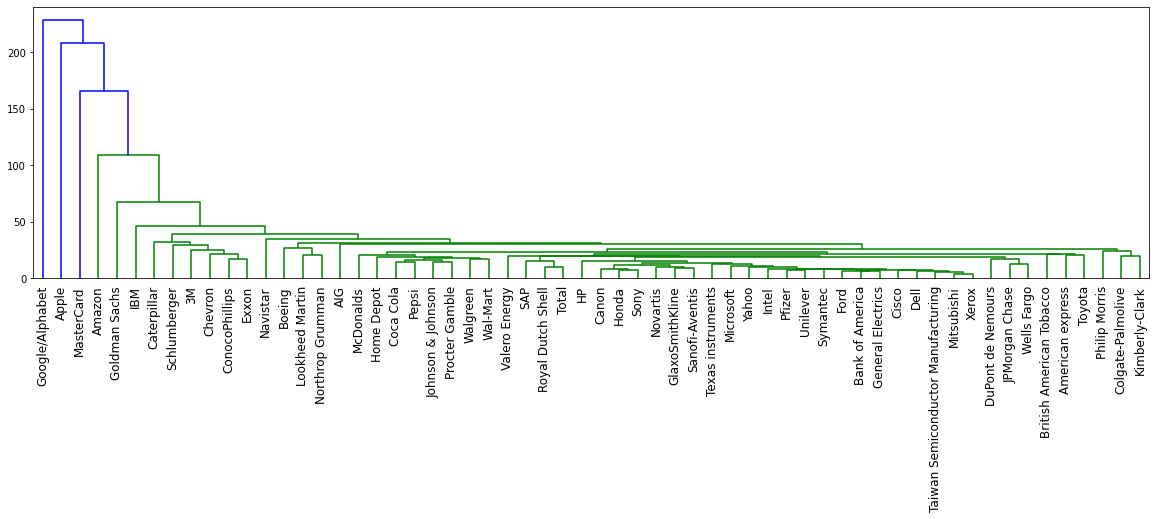

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

model = AgglomerativeClustering(linkage='complete',
                                distance_threshold=0, # to calculate the full tree
                                n_clusters=None)
model = model.fit(X)

# get linkages
links = get_linkage(model)
# plot the dendrogram
fig, ax = plt.subplots(figsize=(20, 5))
dendrogram(links,
           labels=list(df['companies']),
           leaf_rotation=90,
           leaf_font_size=12,
           ax=ax);

### Normalize the movement

Each stock has different valuation, we should not compare them directly. Instead, if we normalize the whole movement as a "unit" vector. They can be compared more equitably.

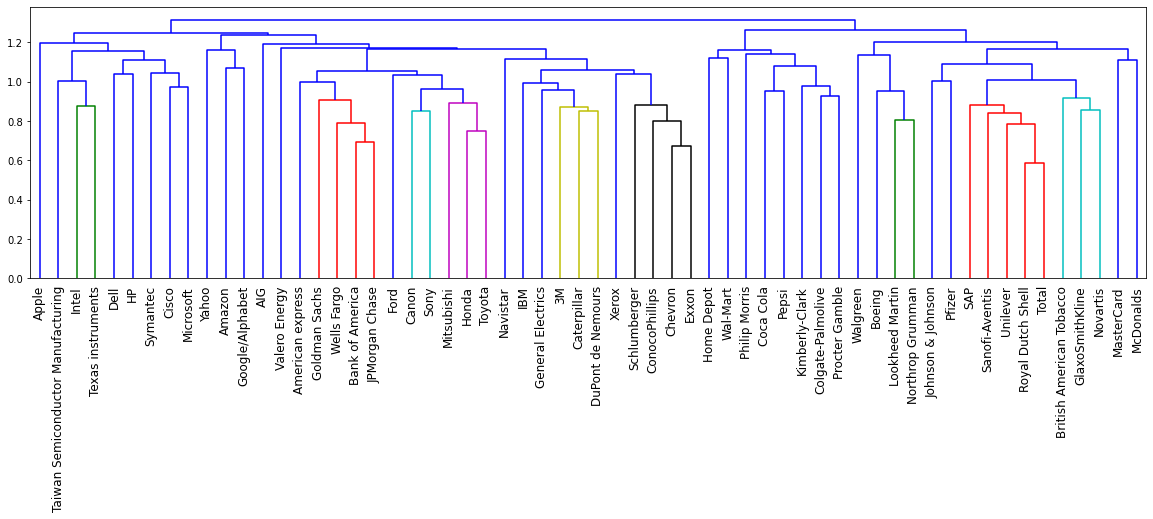

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

# normalize each row to be a unit vector
X_norm = normalize(X)

model = AgglomerativeClustering(linkage='complete',
                                distance_threshold=0,
                                n_clusters=None)
model = model.fit(X_norm)

links = get_linkage(model)

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(20, 5))
dendrogram(links,
           labels=list(df['companies']),
           leaf_rotation=90,
           leaf_font_size=12,
           ax=ax);

## Different linkages

Examples: 'single', 'complete', 'average'.

Read more: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [ ]:
from sklearn.preprocessing import normalize
# normalize each row to be a unit vector
X_norm = normalize(X)

# try some other linkages
model = AgglomerativeClustering(linkage=None,
                                distance_threshold=0,
                                n_clusters=None)
model = model.fit(X_norm)

links = get_linkage(model)

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(20, 5))
dendrogram(links,
           labels=list(df['companies']),
           leaf_rotation=90,
           leaf_font_size=12,
           ax=ax);

## Get the cluster predictions


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

# normalize each row to be a unit vector
X_norm = normalize(X)

model = AgglomerativeClustering(n_clusters=3,
                                linkage='complete')
y_pred = model.fit_predict(X_norm)
print('pred:', y_pred)

pred: [0 0 0 0 1 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 1 0 2 2 1 1 1 0 0 0 0 1
 1 2 1 2 2 1 1 0 0 1 0 0 1 0 0 1 0 1 0 2 0 0 0]


## Estimating the number of clusters with Elbow

Elbow works well with K-means. "Ward" linkage (minimizing variance of a joined cluster) is identical inspirit with K-means in a hierarchical clustering form.

The formulation of Ward is given here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

# normalize each row to be a unit vector
X_norm = normalize(X)

model = AgglomerativeClustering(linkage='ward',
                                distance_threshold=0,
                                n_clusters=None)
model.fit(X_norm)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0, linkage='ward',
                        memory=None, n_clusters=None)

### Plot the "join" distances

If the join distance jumps, it is a sign that it is crossing a natural clustering boundary.

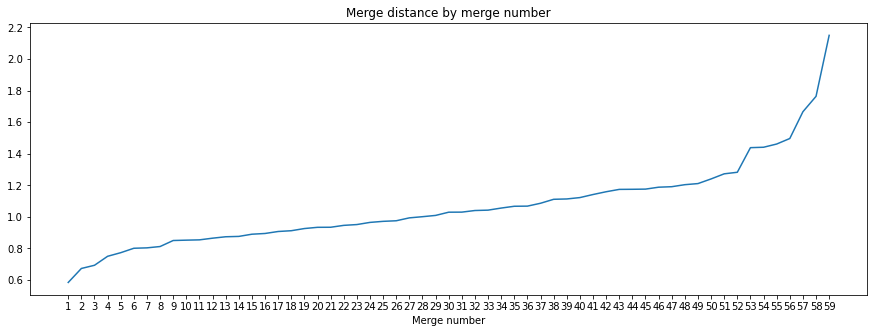

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
xticks = np.arange(1, 60)
ax.set_title('Merge distance by merge number')
ax.set_xticks(xticks)
ax.set_xlabel('Merge number')
ax.plot(xticks, model.distances_)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

# normalize each row to be a unit vector
X_norm = normalize(X)

# 8 seems to be the number of clusters (corresponds to 52 merges)
model = AgglomerativeClustering(linkage='ward',
                                n_clusters=8)
y_pred = model.fit_predict(X_norm)
print(y_pred)

[3 0 3 0 4 0 5 7 6 1 6 2 6 6 2 0 0 3 0 5 1 7 2 2 2 1 0 1 1 4 3 3 6 2 7 0 4
 5 1 1 1 1 5 5 6 7 5 2 7 5 2 2 5 6 1 0 1 6 0 3]


In [ ]:
df2 = pd.DataFrame({
    'companies': df['companies'],
    'cluster': y_pred,
})
df2.head()

,companies,cluster
0,Apple,3
1,AIG,0
2,Amazon,3
3,American express,0
4,Boeing,4


### Grouped by "industries"?

In [ ]:
df2.sort_values('cluster')

,companies,cluster
15,Ford,0
1,AIG,0
3,American express,0
55,Wells Fargo,0
5,Bank of America,0
18,Goldman Sachs,0
16,General Electrics,0
26,JPMorgan Chase,0
35,Navistar,0
58,Xerox,0
